# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.27KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

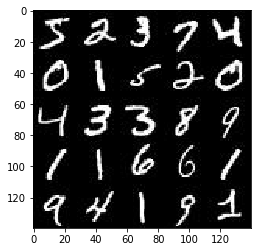

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

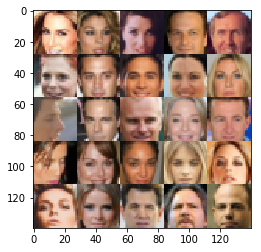

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/zxc012/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(dtype=tf.float32,shape=(None,image_width, image_height, image_channels),
                               name = 'input_real')
    input_z    = tf.placeholder(dtype=tf.float32,shape=(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(dtype=tf.float32)
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x3 or 28x28x1
        dis_net = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * dis_net, dis_net)
        # 14x14x64
        
        x2 = tf.layers.conv2d(inputs=relu1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha=0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        #x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3or1 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real,  reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #model_inputs(image_width, image_height, image_channels, z_dim)
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
        
    #model_loss(input_real, input_z, out_channel_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    #model_opt(d_loss, g_loss, learning_rate, beta1)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                #if steps % show_every == 0:
                #    gen_samples = sess.run(
                #                   generator(input_z, 3, reuse=True, is_train=False),
                #                   feed_dict={input_z: sample_z})
                #    samples.append(gen_samples)
                #    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                #    plt.show()
                
                if steps % 100 == 0:
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
        #saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 25.7376
Epoch 1/2... Discriminator Loss: 6.6242... Generator Loss: 0.0103
Epoch 1/2... Discriminator Loss: 0.5399... Generator Loss: 3.0962
Epoch 1/2... Discriminator Loss: 4.6162... Generator Loss: 5.5701
Epoch 1/2... Discriminator Loss: 0.3372... Generator Loss: 2.7563
Epoch 1/2... Discriminator Loss: 0.7678... Generator Loss: 1.1629
Epoch 1/2... Discriminator Loss: 0.6390... Generator Loss: 1.4526
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 0.5290
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 2.7354
Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 2.9420


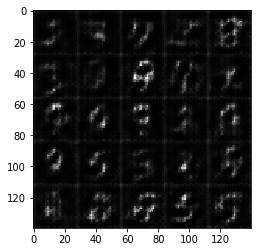

Epoch 1/2... Discriminator Loss: 0.3995... Generator Loss: 2.8951
Epoch 1/2... Discriminator Loss: 0.2664... Generator Loss: 2.6586
Epoch 1/2... Discriminator Loss: 0.2221... Generator Loss: 2.0207
Epoch 1/2... Discriminator Loss: 0.2000... Generator Loss: 2.0324
Epoch 1/2... Discriminator Loss: 0.0631... Generator Loss: 3.2523
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 5.9455
Epoch 1/2... Discriminator Loss: 0.2917... Generator Loss: 2.4542
Epoch 1/2... Discriminator Loss: 2.9823... Generator Loss: 0.0882
Epoch 1/2... Discriminator Loss: 0.9114... Generator Loss: 6.7636
Epoch 1/2... Discriminator Loss: 0.7801... Generator Loss: 3.1525


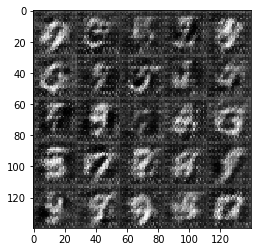

Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 7.7491
Epoch 1/2... Discriminator Loss: 0.6978... Generator Loss: 1.1321
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 0.4105
Epoch 1/2... Discriminator Loss: 6.3631... Generator Loss: 0.0038
Epoch 1/2... Discriminator Loss: 0.6478... Generator Loss: 2.4147
Epoch 1/2... Discriminator Loss: 0.0576... Generator Loss: 4.2610
Epoch 1/2... Discriminator Loss: 0.9130... Generator Loss: 0.6729
Epoch 1/2... Discriminator Loss: 0.0625... Generator Loss: 6.1941
Epoch 1/2... Discriminator Loss: 0.0204... Generator Loss: 9.0415
Epoch 1/2... Discriminator Loss: 1.6731... Generator Loss: 0.2723


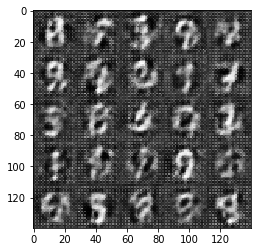

Epoch 1/2... Discriminator Loss: 0.1135... Generator Loss: 5.0916
Epoch 1/2... Discriminator Loss: 2.7011... Generator Loss: 2.9344
Epoch 1/2... Discriminator Loss: 0.7838... Generator Loss: 1.0145
Epoch 1/2... Discriminator Loss: 0.7094... Generator Loss: 1.2220
Epoch 1/2... Discriminator Loss: 0.6044... Generator Loss: 1.3164
Epoch 1/2... Discriminator Loss: 0.2518... Generator Loss: 3.7743
Epoch 1/2... Discriminator Loss: 0.0638... Generator Loss: 3.9489
Epoch 1/2... Discriminator Loss: 0.7946... Generator Loss: 1.0748
Epoch 1/2... Discriminator Loss: 0.1459... Generator Loss: 2.9590
Epoch 1/2... Discriminator Loss: 0.3134... Generator Loss: 6.2646


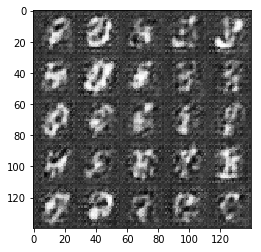

Epoch 1/2... Discriminator Loss: 2.7670... Generator Loss: 5.4708
Epoch 1/2... Discriminator Loss: 0.9960... Generator Loss: 0.7451
Epoch 1/2... Discriminator Loss: 1.4722... Generator Loss: 0.3717
Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 0.6348
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 0.6351
Epoch 1/2... Discriminator Loss: 0.2973... Generator Loss: 1.9058
Epoch 1/2... Discriminator Loss: 0.1296... Generator Loss: 3.2915
Epoch 1/2... Discriminator Loss: 0.1138... Generator Loss: 3.0625
Epoch 1/2... Discriminator Loss: 0.0338... Generator Loss: 5.9980
Epoch 1/2... Discriminator Loss: 0.0438... Generator Loss: 3.7823


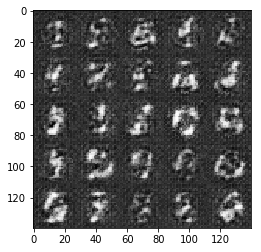

Epoch 1/2... Discriminator Loss: 0.0247... Generator Loss: 7.0105
Epoch 1/2... Discriminator Loss: 0.7618... Generator Loss: 0.8016
Epoch 1/2... Discriminator Loss: 1.5445... Generator Loss: 4.3493
Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 1.2170
Epoch 1/2... Discriminator Loss: 0.5149... Generator Loss: 1.2737
Epoch 1/2... Discriminator Loss: 0.8409... Generator Loss: 1.2678
Epoch 1/2... Discriminator Loss: 0.7121... Generator Loss: 1.1252
Epoch 1/2... Discriminator Loss: 0.2873... Generator Loss: 2.0036
Epoch 1/2... Discriminator Loss: 0.2266... Generator Loss: 1.8606
Epoch 1/2... Discriminator Loss: 0.2751... Generator Loss: 1.8172


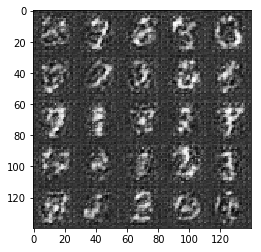

Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 0.4263
Epoch 1/2... Discriminator Loss: 0.9297... Generator Loss: 0.9711
Epoch 1/2... Discriminator Loss: 0.7622... Generator Loss: 1.2150
Epoch 1/2... Discriminator Loss: 0.6206... Generator Loss: 1.4798
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 0.7874
Epoch 1/2... Discriminator Loss: 0.6956... Generator Loss: 1.0170
Epoch 1/2... Discriminator Loss: 0.8762... Generator Loss: 0.8112
Epoch 1/2... Discriminator Loss: 0.6873... Generator Loss: 1.0309
Epoch 1/2... Discriminator Loss: 0.5090... Generator Loss: 1.5519
Epoch 1/2... Discriminator Loss: 0.4678... Generator Loss: 2.1742


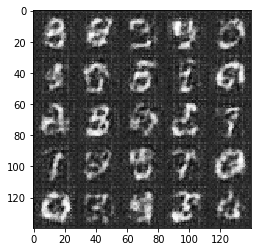

Epoch 1/2... Discriminator Loss: 0.5644... Generator Loss: 1.2365
Epoch 1/2... Discriminator Loss: 0.1971... Generator Loss: 2.1196
Epoch 1/2... Discriminator Loss: 0.1031... Generator Loss: 2.9022
Epoch 1/2... Discriminator Loss: 0.0701... Generator Loss: 3.4199
Epoch 1/2... Discriminator Loss: 0.1968... Generator Loss: 2.1619
Epoch 1/2... Discriminator Loss: 0.1789... Generator Loss: 2.1436
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 2.4931
Epoch 1/2... Discriminator Loss: 0.5083... Generator Loss: 2.0032
Epoch 1/2... Discriminator Loss: 0.8310... Generator Loss: 0.7839
Epoch 1/2... Discriminator Loss: 0.8668... Generator Loss: 0.7125


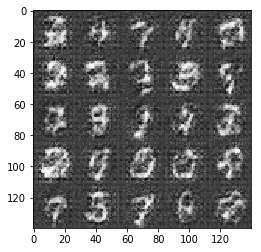

Epoch 1/2... Discriminator Loss: 0.2797... Generator Loss: 1.6586
Epoch 1/2... Discriminator Loss: 0.6259... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 0.0844... Generator Loss: 3.3681
Epoch 1/2... Discriminator Loss: 0.0451... Generator Loss: 4.1159
Epoch 1/2... Discriminator Loss: 0.0408... Generator Loss: 4.1008
Epoch 1/2... Discriminator Loss: 0.1014... Generator Loss: 2.8178
Epoch 1/2... Discriminator Loss: 0.2414... Generator Loss: 1.8887
Epoch 1/2... Discriminator Loss: 0.2028... Generator Loss: 1.9330
Epoch 1/2... Discriminator Loss: 0.0751... Generator Loss: 3.0654
Epoch 1/2... Discriminator Loss: 0.0441... Generator Loss: 3.3974


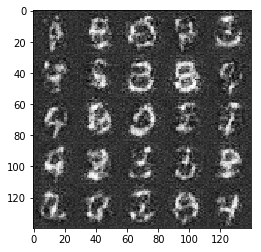

Epoch 1/2... Discriminator Loss: 0.0271... Generator Loss: 4.2703
Epoch 1/2... Discriminator Loss: 0.0037... Generator Loss: 6.4830
Epoch 1/2... Discriminator Loss: 0.0207... Generator Loss: 4.7441
Epoch 1/2... Discriminator Loss: 0.0136... Generator Loss: 5.5295
Epoch 1/2... Discriminator Loss: 0.0243... Generator Loss: 4.4592
Epoch 1/2... Discriminator Loss: 0.0226... Generator Loss: 4.3654
Epoch 1/2... Discriminator Loss: 0.0023... Generator Loss: 8.9034
Epoch 1/2... Discriminator Loss: 1.0415... Generator Loss: 2.1604
Epoch 1/2... Discriminator Loss: 0.6257... Generator Loss: 2.3381
Epoch 1/2... Discriminator Loss: 0.7185... Generator Loss: 2.3958


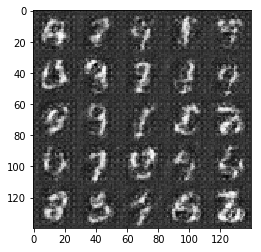

Epoch 1/2... Discriminator Loss: 0.4020... Generator Loss: 1.6300
Epoch 1/2... Discriminator Loss: 0.8373... Generator Loss: 0.7230
Epoch 1/2... Discriminator Loss: 0.6473... Generator Loss: 1.1654
Epoch 1/2... Discriminator Loss: 0.5491... Generator Loss: 1.4381
Epoch 1/2... Discriminator Loss: 0.4047... Generator Loss: 1.5638
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 0.7746
Epoch 1/2... Discriminator Loss: 0.3137... Generator Loss: 1.7466
Epoch 1/2... Discriminator Loss: 0.5070... Generator Loss: 1.1134
Epoch 1/2... Discriminator Loss: 0.1768... Generator Loss: 2.3024
Epoch 1/2... Discriminator Loss: 0.5352... Generator Loss: 1.0875


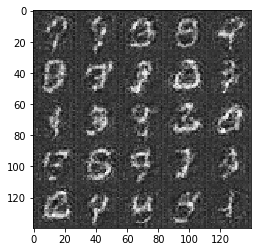

Epoch 1/2... Discriminator Loss: 0.2367... Generator Loss: 1.9387
Epoch 1/2... Discriminator Loss: 0.2705... Generator Loss: 1.6421
Epoch 1/2... Discriminator Loss: 0.1308... Generator Loss: 2.6672
Epoch 1/2... Discriminator Loss: 0.0377... Generator Loss: 3.7841
Epoch 1/2... Discriminator Loss: 0.2547... Generator Loss: 1.8822
Epoch 1/2... Discriminator Loss: 0.0868... Generator Loss: 2.8725
Epoch 1/2... Discriminator Loss: 0.0285... Generator Loss: 4.1196
Epoch 1/2... Discriminator Loss: 0.0285... Generator Loss: 4.4243
Epoch 1/2... Discriminator Loss: 0.0110... Generator Loss: 6.2200
Epoch 1/2... Discriminator Loss: 0.1692... Generator Loss: 2.2756


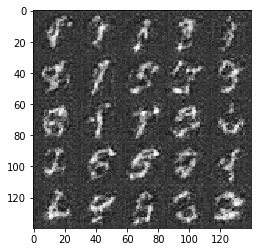

Epoch 1/2... Discriminator Loss: 0.0098... Generator Loss: 5.3908
Epoch 1/2... Discriminator Loss: 0.0192... Generator Loss: 4.7830
Epoch 1/2... Discriminator Loss: 0.1555... Generator Loss: 2.2523
Epoch 1/2... Discriminator Loss: 0.0386... Generator Loss: 3.8813
Epoch 1/2... Discriminator Loss: 0.0115... Generator Loss: 5.5730
Epoch 1/2... Discriminator Loss: 0.0737... Generator Loss: 3.3245
Epoch 1/2... Discriminator Loss: 0.0419... Generator Loss: 3.6552
Epoch 1/2... Discriminator Loss: 0.0346... Generator Loss: 3.7900
Epoch 1/2... Discriminator Loss: 0.0539... Generator Loss: 3.5078
Epoch 1/2... Discriminator Loss: 0.0787... Generator Loss: 3.1566


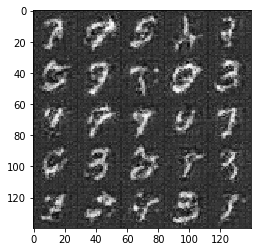

Epoch 1/2... Discriminator Loss: 0.0453... Generator Loss: 4.2668
Epoch 1/2... Discriminator Loss: 0.0514... Generator Loss: 3.6217
Epoch 1/2... Discriminator Loss: 0.0683... Generator Loss: 3.1901
Epoch 1/2... Discriminator Loss: 0.0954... Generator Loss: 2.8477
Epoch 1/2... Discriminator Loss: 2.9086... Generator Loss: 0.1347
Epoch 1/2... Discriminator Loss: 0.6943... Generator Loss: 1.4764
Epoch 1/2... Discriminator Loss: 0.6568... Generator Loss: 1.4234
Epoch 1/2... Discriminator Loss: 0.7925... Generator Loss: 0.8794
Epoch 1/2... Discriminator Loss: 0.4324... Generator Loss: 1.6928
Epoch 1/2... Discriminator Loss: 0.2738... Generator Loss: 2.0941


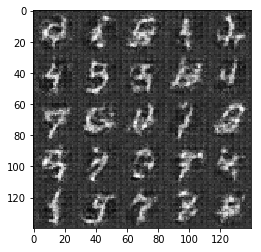

Epoch 1/2... Discriminator Loss: 0.4507... Generator Loss: 1.5998
Epoch 1/2... Discriminator Loss: 0.6960... Generator Loss: 0.9974
Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 0.7283
Epoch 1/2... Discriminator Loss: 0.6255... Generator Loss: 2.6136
Epoch 1/2... Discriminator Loss: 0.2121... Generator Loss: 3.0750
Epoch 1/2... Discriminator Loss: 0.2643... Generator Loss: 1.9251
Epoch 1/2... Discriminator Loss: 0.5759... Generator Loss: 1.3373
Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 1.2885
Epoch 1/2... Discriminator Loss: 0.3509... Generator Loss: 2.2128
Epoch 1/2... Discriminator Loss: 0.4770... Generator Loss: 1.6355


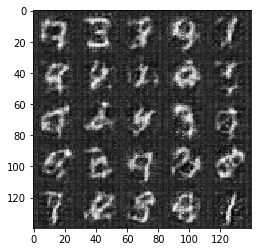

Epoch 1/2... Discriminator Loss: 0.3158... Generator Loss: 1.9207
Epoch 1/2... Discriminator Loss: 0.4875... Generator Loss: 1.2848
Epoch 1/2... Discriminator Loss: 1.6906... Generator Loss: 0.2682
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 1.2764
Epoch 1/2... Discriminator Loss: 0.3763... Generator Loss: 1.4000
Epoch 1/2... Discriminator Loss: 0.4129... Generator Loss: 1.4022
Epoch 1/2... Discriminator Loss: 0.3378... Generator Loss: 1.7054
Epoch 1/2... Discriminator Loss: 0.1194... Generator Loss: 2.8741
Epoch 1/2... Discriminator Loss: 0.4786... Generator Loss: 1.3432
Epoch 1/2... Discriminator Loss: 0.7487... Generator Loss: 0.8526


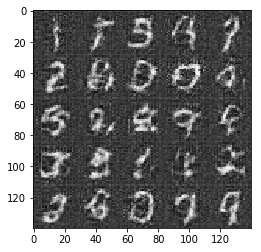

Epoch 1/2... Discriminator Loss: 0.0391... Generator Loss: 3.8343
Epoch 1/2... Discriminator Loss: 0.1500... Generator Loss: 2.4998
Epoch 1/2... Discriminator Loss: 0.1766... Generator Loss: 2.4951
Epoch 1/2... Discriminator Loss: 0.0294... Generator Loss: 4.8252
Epoch 1/2... Discriminator Loss: 0.2596... Generator Loss: 1.7184
Epoch 1/2... Discriminator Loss: 1.8732... Generator Loss: 0.4398
Epoch 1/2... Discriminator Loss: 0.6808... Generator Loss: 2.6335
Epoch 1/2... Discriminator Loss: 0.4165... Generator Loss: 1.4354
Epoch 1/2... Discriminator Loss: 1.0247... Generator Loss: 0.7076
Epoch 1/2... Discriminator Loss: 0.6465... Generator Loss: 1.0903


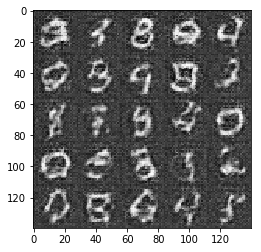

Epoch 1/2... Discriminator Loss: 1.8211... Generator Loss: 5.7036
Epoch 1/2... Discriminator Loss: 0.6548... Generator Loss: 0.9664
Epoch 1/2... Discriminator Loss: 0.5115... Generator Loss: 1.2344
Epoch 1/2... Discriminator Loss: 1.3020... Generator Loss: 0.4835
Epoch 1/2... Discriminator Loss: 0.2778... Generator Loss: 1.7147
Epoch 1/2... Discriminator Loss: 0.4672... Generator Loss: 1.2939
Epoch 1/2... Discriminator Loss: 0.2294... Generator Loss: 2.4779
Epoch 1/2... Discriminator Loss: 0.2672... Generator Loss: 1.7847
Epoch 1/2... Discriminator Loss: 0.1280... Generator Loss: 2.7218
Epoch 1/2... Discriminator Loss: 0.1197... Generator Loss: 2.8247


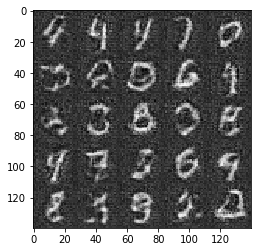

Epoch 1/2... Discriminator Loss: 0.5160... Generator Loss: 1.2742
Epoch 1/2... Discriminator Loss: 0.2457... Generator Loss: 1.8991
Epoch 1/2... Discriminator Loss: 0.5783... Generator Loss: 1.0837
Epoch 1/2... Discriminator Loss: 0.1304... Generator Loss: 2.4857
Epoch 1/2... Discriminator Loss: 0.1118... Generator Loss: 2.7927
Epoch 1/2... Discriminator Loss: 0.2893... Generator Loss: 1.8766
Epoch 1/2... Discriminator Loss: 0.3971... Generator Loss: 1.9842
Epoch 2/2... Discriminator Loss: 0.0822... Generator Loss: 3.2986
Epoch 2/2... Discriminator Loss: 0.0682... Generator Loss: 3.1609
Epoch 2/2... Discriminator Loss: 0.0773... Generator Loss: 2.9269


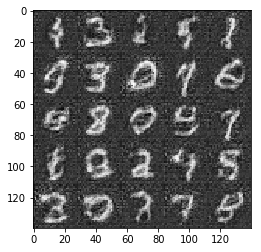

Epoch 2/2... Discriminator Loss: 0.0493... Generator Loss: 3.5824
Epoch 2/2... Discriminator Loss: 2.2477... Generator Loss: 2.3349
Epoch 2/2... Discriminator Loss: 1.2496... Generator Loss: 0.5251
Epoch 2/2... Discriminator Loss: 0.8862... Generator Loss: 0.9836
Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 2.8187
Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 3.0934
Epoch 2/2... Discriminator Loss: 0.5679... Generator Loss: 2.1848
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 4.4812
Epoch 2/2... Discriminator Loss: 0.6857... Generator Loss: 2.3029
Epoch 2/2... Discriminator Loss: 0.8120... Generator Loss: 0.9408


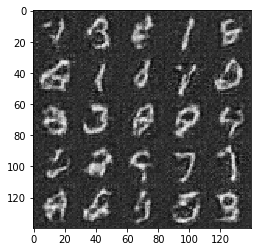

Epoch 2/2... Discriminator Loss: 1.2750... Generator Loss: 3.6956
Epoch 2/2... Discriminator Loss: 0.5483... Generator Loss: 1.2571
Epoch 2/2... Discriminator Loss: 0.8516... Generator Loss: 3.7503
Epoch 2/2... Discriminator Loss: 0.4314... Generator Loss: 1.9189
Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 4.2705
Epoch 2/2... Discriminator Loss: 1.1538... Generator Loss: 4.5376
Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 3.3129
Epoch 2/2... Discriminator Loss: 0.2277... Generator Loss: 2.1117
Epoch 2/2... Discriminator Loss: 2.0474... Generator Loss: 0.2157
Epoch 2/2... Discriminator Loss: 0.3656... Generator Loss: 2.8595


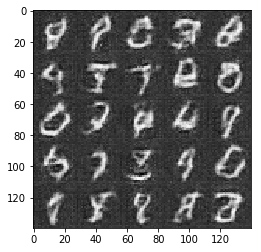

Epoch 2/2... Discriminator Loss: 0.2734... Generator Loss: 1.9337
Epoch 2/2... Discriminator Loss: 0.2903... Generator Loss: 1.9200
Epoch 2/2... Discriminator Loss: 0.2289... Generator Loss: 2.0689
Epoch 2/2... Discriminator Loss: 0.4499... Generator Loss: 1.3522
Epoch 2/2... Discriminator Loss: 0.2522... Generator Loss: 1.9947
Epoch 2/2... Discriminator Loss: 0.3450... Generator Loss: 1.6124
Epoch 2/2... Discriminator Loss: 0.2766... Generator Loss: 1.6761
Epoch 2/2... Discriminator Loss: 0.0404... Generator Loss: 3.6928
Epoch 2/2... Discriminator Loss: 0.1677... Generator Loss: 2.1089
Epoch 2/2... Discriminator Loss: 0.0931... Generator Loss: 3.0371


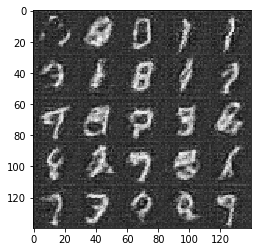

Epoch 2/2... Discriminator Loss: 0.3564... Generator Loss: 1.4016
Epoch 2/2... Discriminator Loss: 0.0378... Generator Loss: 4.3289
Epoch 2/2... Discriminator Loss: 0.0887... Generator Loss: 2.9087
Epoch 2/2... Discriminator Loss: 0.3444... Generator Loss: 1.5208
Epoch 2/2... Discriminator Loss: 0.2055... Generator Loss: 2.0024
Epoch 2/2... Discriminator Loss: 0.0102... Generator Loss: 5.5768
Epoch 2/2... Discriminator Loss: 0.0340... Generator Loss: 3.9419
Epoch 2/2... Discriminator Loss: 0.1240... Generator Loss: 2.5555
Epoch 2/2... Discriminator Loss: 0.0158... Generator Loss: 4.9117
Epoch 2/2... Discriminator Loss: 0.0749... Generator Loss: 3.0825


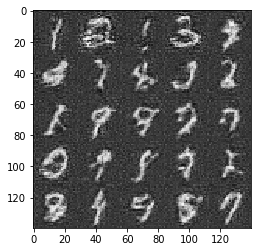

Epoch 2/2... Discriminator Loss: 0.0121... Generator Loss: 5.2570
Epoch 2/2... Discriminator Loss: 0.1215... Generator Loss: 2.5409
Epoch 2/2... Discriminator Loss: 0.1317... Generator Loss: 2.5914
Epoch 2/2... Discriminator Loss: 0.0605... Generator Loss: 3.2409
Epoch 2/2... Discriminator Loss: 0.0301... Generator Loss: 4.0399
Epoch 2/2... Discriminator Loss: 0.0503... Generator Loss: 3.6158
Epoch 2/2... Discriminator Loss: 0.0308... Generator Loss: 4.2223
Epoch 2/2... Discriminator Loss: 0.0373... Generator Loss: 3.8932
Epoch 2/2... Discriminator Loss: 0.0143... Generator Loss: 4.7453
Epoch 2/2... Discriminator Loss: 0.0647... Generator Loss: 3.5108


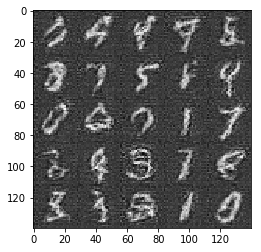

Epoch 2/2... Discriminator Loss: 0.0228... Generator Loss: 4.2369
Epoch 2/2... Discriminator Loss: 0.0908... Generator Loss: 3.1874
Epoch 2/2... Discriminator Loss: 0.0101... Generator Loss: 5.4875
Epoch 2/2... Discriminator Loss: 0.0153... Generator Loss: 4.7326
Epoch 2/2... Discriminator Loss: 0.0233... Generator Loss: 4.5771
Epoch 2/2... Discriminator Loss: 0.0293... Generator Loss: 4.0017
Epoch 2/2... Discriminator Loss: 0.0051... Generator Loss: 6.1268
Epoch 2/2... Discriminator Loss: 0.0210... Generator Loss: 4.5791
Epoch 2/2... Discriminator Loss: 0.0327... Generator Loss: 3.8618
Epoch 2/2... Discriminator Loss: 0.0089... Generator Loss: 5.4829


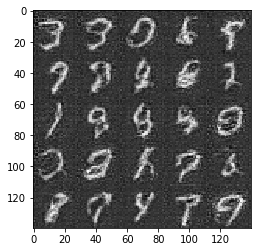

Epoch 2/2... Discriminator Loss: 0.0489... Generator Loss: 3.5031
Epoch 2/2... Discriminator Loss: 0.0114... Generator Loss: 5.5186
Epoch 2/2... Discriminator Loss: 0.0080... Generator Loss: 5.8103
Epoch 2/2... Discriminator Loss: 0.0327... Generator Loss: 3.8315
Epoch 2/2... Discriminator Loss: 0.0176... Generator Loss: 4.6819
Epoch 2/2... Discriminator Loss: 0.0104... Generator Loss: 5.7652
Epoch 2/2... Discriminator Loss: 0.0164... Generator Loss: 4.5483
Epoch 2/2... Discriminator Loss: 0.0349... Generator Loss: 3.8402
Epoch 2/2... Discriminator Loss: 0.0440... Generator Loss: 3.6419
Epoch 2/2... Discriminator Loss: 0.0293... Generator Loss: 4.1092


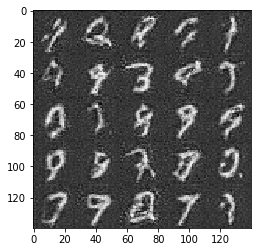

Epoch 2/2... Discriminator Loss: 0.0349... Generator Loss: 4.0058
Epoch 2/2... Discriminator Loss: 0.0098... Generator Loss: 5.4084
Epoch 2/2... Discriminator Loss: 20.6210... Generator Loss: 21.8978
Epoch 2/2... Discriminator Loss: 2.0610... Generator Loss: 3.3442
Epoch 2/2... Discriminator Loss: 1.8434... Generator Loss: 0.3650
Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 1.2506
Epoch 2/2... Discriminator Loss: 0.8624... Generator Loss: 0.9448
Epoch 2/2... Discriminator Loss: 0.6952... Generator Loss: 1.2434
Epoch 2/2... Discriminator Loss: 1.4389... Generator Loss: 0.4320
Epoch 2/2... Discriminator Loss: 0.8019... Generator Loss: 1.4890


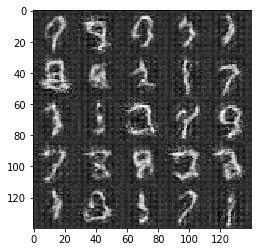

Epoch 2/2... Discriminator Loss: 0.7793... Generator Loss: 1.5909
Epoch 2/2... Discriminator Loss: 1.1177... Generator Loss: 0.7048
Epoch 2/2... Discriminator Loss: 0.9819... Generator Loss: 3.3839
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.6181
Epoch 2/2... Discriminator Loss: 1.0782... Generator Loss: 2.1954
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 2.8172
Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 1.4158
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 3.0228
Epoch 2/2... Discriminator Loss: 2.1516... Generator Loss: 0.2113
Epoch 2/2... Discriminator Loss: 0.5435... Generator Loss: 1.6341


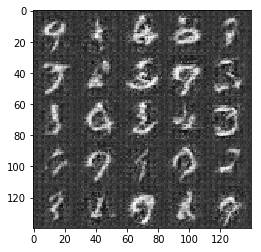

Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 2.0833
Epoch 2/2... Discriminator Loss: 0.5543... Generator Loss: 1.6388
Epoch 2/2... Discriminator Loss: 0.5778... Generator Loss: 1.5261
Epoch 2/2... Discriminator Loss: 0.5162... Generator Loss: 1.4403
Epoch 2/2... Discriminator Loss: 0.6365... Generator Loss: 3.0285
Epoch 2/2... Discriminator Loss: 0.3746... Generator Loss: 1.7336
Epoch 2/2... Discriminator Loss: 0.5612... Generator Loss: 1.1974
Epoch 2/2... Discriminator Loss: 0.5505... Generator Loss: 2.1511
Epoch 2/2... Discriminator Loss: 0.7774... Generator Loss: 3.3317
Epoch 2/2... Discriminator Loss: 0.4484... Generator Loss: 1.8154


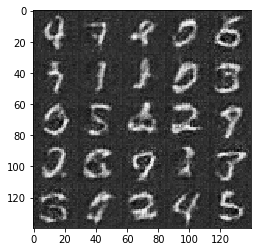

Epoch 2/2... Discriminator Loss: 1.8789... Generator Loss: 0.2464
Epoch 2/2... Discriminator Loss: 0.4375... Generator Loss: 1.5639
Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 3.6799
Epoch 2/2... Discriminator Loss: 0.4354... Generator Loss: 1.6417
Epoch 2/2... Discriminator Loss: 1.3992... Generator Loss: 0.4266
Epoch 2/2... Discriminator Loss: 0.5837... Generator Loss: 1.3328
Epoch 2/2... Discriminator Loss: 0.6341... Generator Loss: 2.9670
Epoch 2/2... Discriminator Loss: 0.6186... Generator Loss: 1.0852
Epoch 2/2... Discriminator Loss: 0.3831... Generator Loss: 3.2302
Epoch 2/2... Discriminator Loss: 0.2422... Generator Loss: 2.6680


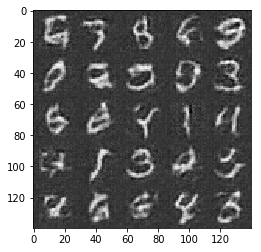

Epoch 2/2... Discriminator Loss: 0.6183... Generator Loss: 1.7736
Epoch 2/2... Discriminator Loss: 0.3988... Generator Loss: 1.5568
Epoch 2/2... Discriminator Loss: 0.4170... Generator Loss: 2.6228
Epoch 2/2... Discriminator Loss: 0.3245... Generator Loss: 2.1693
Epoch 2/2... Discriminator Loss: 0.3195... Generator Loss: 1.8749
Epoch 2/2... Discriminator Loss: 0.4754... Generator Loss: 1.3530
Epoch 2/2... Discriminator Loss: 0.2209... Generator Loss: 2.3443
Epoch 2/2... Discriminator Loss: 0.1233... Generator Loss: 2.8756
Epoch 2/2... Discriminator Loss: 0.4978... Generator Loss: 1.3634
Epoch 2/2... Discriminator Loss: 0.2503... Generator Loss: 2.0214


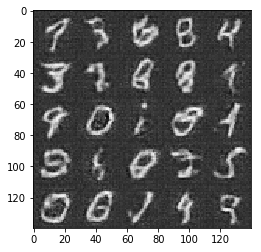

Epoch 2/2... Discriminator Loss: 0.2602... Generator Loss: 1.7923
Epoch 2/2... Discriminator Loss: 0.1554... Generator Loss: 2.6040
Epoch 2/2... Discriminator Loss: 0.1013... Generator Loss: 2.8141
Epoch 2/2... Discriminator Loss: 0.0725... Generator Loss: 4.1864
Epoch 2/2... Discriminator Loss: 0.1096... Generator Loss: 2.6391
Epoch 2/2... Discriminator Loss: 0.2003... Generator Loss: 2.1742
Epoch 2/2... Discriminator Loss: 0.1123... Generator Loss: 2.9070
Epoch 2/2... Discriminator Loss: 0.0908... Generator Loss: 2.9267
Epoch 2/2... Discriminator Loss: 0.3471... Generator Loss: 1.8157
Epoch 2/2... Discriminator Loss: 0.1195... Generator Loss: 2.5314


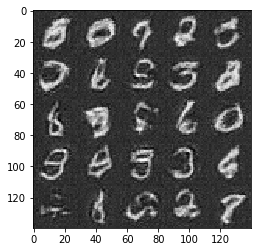

Epoch 2/2... Discriminator Loss: 0.6370... Generator Loss: 1.5897
Epoch 2/2... Discriminator Loss: 0.3793... Generator Loss: 2.1509
Epoch 2/2... Discriminator Loss: 0.4820... Generator Loss: 1.3163
Epoch 2/2... Discriminator Loss: 0.7461... Generator Loss: 0.9317
Epoch 2/2... Discriminator Loss: 0.2803... Generator Loss: 1.7703
Epoch 2/2... Discriminator Loss: 0.2171... Generator Loss: 2.1144
Epoch 2/2... Discriminator Loss: 0.0794... Generator Loss: 3.2298
Epoch 2/2... Discriminator Loss: 0.1857... Generator Loss: 2.2875
Epoch 2/2... Discriminator Loss: 0.2088... Generator Loss: 2.3457
Epoch 2/2... Discriminator Loss: 0.2076... Generator Loss: 2.1166


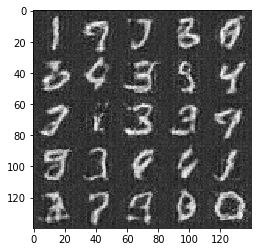

Epoch 2/2... Discriminator Loss: 0.5341... Generator Loss: 1.2495
Epoch 2/2... Discriminator Loss: 0.3417... Generator Loss: 1.7998
Epoch 2/2... Discriminator Loss: 0.0438... Generator Loss: 4.1046
Epoch 2/2... Discriminator Loss: 0.0357... Generator Loss: 3.9298
Epoch 2/2... Discriminator Loss: 0.2777... Generator Loss: 1.8153
Epoch 2/2... Discriminator Loss: 0.0370... Generator Loss: 4.4814
Epoch 2/2... Discriminator Loss: 0.0099... Generator Loss: 5.8201
Epoch 2/2... Discriminator Loss: 0.1630... Generator Loss: 2.2401
Epoch 2/2... Discriminator Loss: 0.0861... Generator Loss: 2.8749
Epoch 2/2... Discriminator Loss: 0.0889... Generator Loss: 2.9467


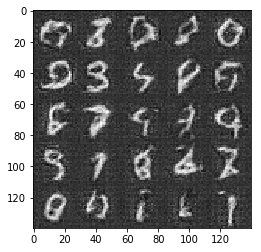

Epoch 2/2... Discriminator Loss: 0.0333... Generator Loss: 4.2044
Epoch 2/2... Discriminator Loss: 0.0285... Generator Loss: 4.0873
Epoch 2/2... Discriminator Loss: 0.0287... Generator Loss: 4.1130
Epoch 2/2... Discriminator Loss: 0.0708... Generator Loss: 3.3076
Epoch 2/2... Discriminator Loss: 0.2045... Generator Loss: 2.2242
Epoch 2/2... Discriminator Loss: 0.0894... Generator Loss: 3.1204
Epoch 2/2... Discriminator Loss: 0.0220... Generator Loss: 4.6902
Epoch 2/2... Discriminator Loss: 0.1021... Generator Loss: 2.9698
Epoch 2/2... Discriminator Loss: 0.0312... Generator Loss: 4.1034
Epoch 2/2... Discriminator Loss: 0.0355... Generator Loss: 3.7391


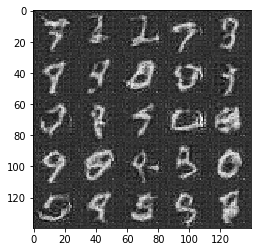

Epoch 2/2... Discriminator Loss: 0.0112... Generator Loss: 5.1860
Epoch 2/2... Discriminator Loss: 0.1056... Generator Loss: 3.2277
Epoch 2/2... Discriminator Loss: 0.0507... Generator Loss: 3.6264
Epoch 2/2... Discriminator Loss: 0.0151... Generator Loss: 4.8826
Epoch 2/2... Discriminator Loss: 0.0260... Generator Loss: 4.1637
Epoch 2/2... Discriminator Loss: 0.0068... Generator Loss: 5.8715
Epoch 2/2... Discriminator Loss: 0.0162... Generator Loss: 4.4738
Epoch 2/2... Discriminator Loss: 0.0663... Generator Loss: 3.0710
Epoch 2/2... Discriminator Loss: 0.0694... Generator Loss: 3.1841
Epoch 2/2... Discriminator Loss: 0.0182... Generator Loss: 4.4239


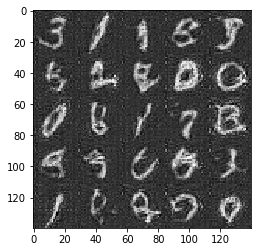

Epoch 2/2... Discriminator Loss: 0.0345... Generator Loss: 4.1004
Epoch 2/2... Discriminator Loss: 0.0061... Generator Loss: 5.6079
Epoch 2/2... Discriminator Loss: 0.0149... Generator Loss: 4.6829
Epoch 2/2... Discriminator Loss: 0.0283... Generator Loss: 4.2715
Epoch 2/2... Discriminator Loss: 0.0022... Generator Loss: 6.9740
Epoch 2/2... Discriminator Loss: 0.1252... Generator Loss: 2.9320
Epoch 2/2... Discriminator Loss: 0.0011... Generator Loss: 7.5685
Epoch 2/2... Discriminator Loss: 0.0740... Generator Loss: 3.1448
Epoch 2/2... Discriminator Loss: 0.0090... Generator Loss: 5.3304
Epoch 2/2... Discriminator Loss: 0.1019... Generator Loss: 2.9818


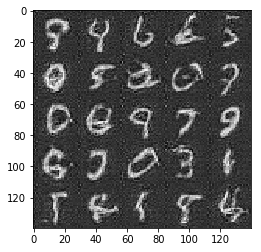

Epoch 2/2... Discriminator Loss: 0.1027... Generator Loss: 2.8273
Epoch 2/2... Discriminator Loss: 0.0283... Generator Loss: 4.2266
Epoch 2/2... Discriminator Loss: 0.0034... Generator Loss: 8.1946
Epoch 2/2... Discriminator Loss: 0.0378... Generator Loss: 3.8196
Epoch 2/2... Discriminator Loss: 0.0347... Generator Loss: 4.0002


ValueError: Parent directory of ./checkpoints/generator.ckpt doesn't exist, can't save.

In [31]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0442... Generator Loss: 9.7912
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 15.3014
Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 24.4514
Epoch 1/1... Discriminator Loss: 0.0337... Generator Loss: 6.8333
Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 1.5901
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 1.3999
Epoch 1/1... Discriminator Loss: 0.3235... Generator Loss: 2.4231
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 2.5065... Generator Loss: 10.0582
Epoch 1/1... Discriminator Loss: 0.0328... Generator Loss: 5.3463


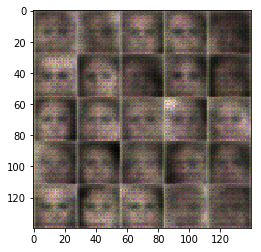

Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 0.0238... Generator Loss: 5.7944
Epoch 1/1... Discriminator Loss: 0.1317... Generator Loss: 3.8340
Epoch 1/1... Discriminator Loss: 0.0667... Generator Loss: 5.4777
Epoch 1/1... Discriminator Loss: 0.0512... Generator Loss: 3.5325
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 9.4321
Epoch 1/1... Discriminator Loss: 0.2310... Generator Loss: 2.4005
Epoch 1/1... Discriminator Loss: 0.0626... Generator Loss: 4.3380
Epoch 1/1... Discriminator Loss: 1.8619... Generator Loss: 1.5294
Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 3.3116


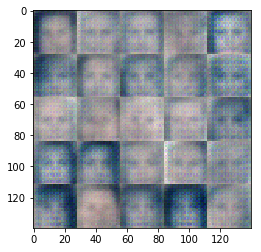

Epoch 1/1... Discriminator Loss: 0.2585... Generator Loss: 4.5561
Epoch 1/1... Discriminator Loss: 0.0925... Generator Loss: 4.6899
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 2.4323
Epoch 1/1... Discriminator Loss: 0.0299... Generator Loss: 6.1840
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 13.4311
Epoch 1/1... Discriminator Loss: 0.0377... Generator Loss: 3.5943
Epoch 1/1... Discriminator Loss: 0.0195... Generator Loss: 4.7394
Epoch 1/1... Discriminator Loss: 0.7279... Generator Loss: 1.3768
Epoch 1/1... Discriminator Loss: 0.1814... Generator Loss: 2.2990
Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 1.4040


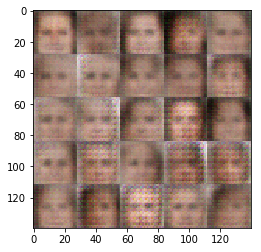

Epoch 1/1... Discriminator Loss: 0.1043... Generator Loss: 8.2059
Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 4.3407
Epoch 1/1... Discriminator Loss: 0.1817... Generator Loss: 2.1253
Epoch 1/1... Discriminator Loss: 0.0874... Generator Loss: 2.7889
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 6.4965
Epoch 1/1... Discriminator Loss: 0.1141... Generator Loss: 13.1146
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 11.2297
Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 8.9806
Epoch 1/1... Discriminator Loss: 0.0213... Generator Loss: 8.2443
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 11.8456


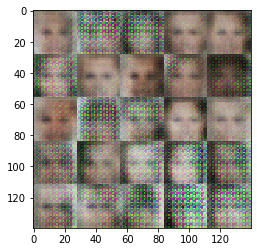

Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 7.4216
Epoch 1/1... Discriminator Loss: 0.1536... Generator Loss: 2.3573
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 7.7811
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 8.1552
Epoch 1/1... Discriminator Loss: 0.0621... Generator Loss: 5.0703
Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 4.3779
Epoch 1/1... Discriminator Loss: 0.0981... Generator Loss: 2.7844
Epoch 1/1... Discriminator Loss: 0.0466... Generator Loss: 3.4789
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 6.1562
Epoch 1/1... Discriminator Loss: 0.0331... Generator Loss: 4.5959


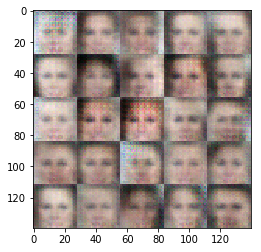

Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 9.6899
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 3.4282
Epoch 1/1... Discriminator Loss: 0.3207... Generator Loss: 1.5984
Epoch 1/1... Discriminator Loss: 0.0104... Generator Loss: 8.9237
Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 8.4885
Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 6.5403
Epoch 1/1... Discriminator Loss: 0.0457... Generator Loss: 3.7762
Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 5.3800
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 9.7667
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 9.4318


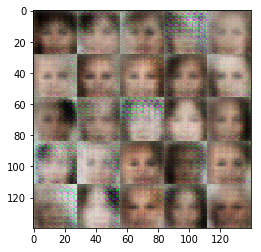

Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 10.4991
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 0.0618... Generator Loss: 3.1921
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 7.7218
Epoch 1/1... Discriminator Loss: 0.0078... Generator Loss: 9.9616
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 11.8135
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 11.9097
Epoch 1/1... Discriminator Loss: 0.0132... Generator Loss: 4.9961
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 8.2600
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 8.4408


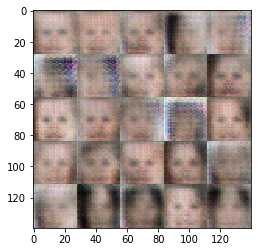

Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 8.1988
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 9.7399
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 5.8897
Epoch 1/1... Discriminator Loss: 0.0079... Generator Loss: 5.5444
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 5.5757
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 10.4637
Epoch 1/1... Discriminator Loss: 2.4315... Generator Loss: 7.3982
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 9.6570
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 6.8863
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 8.4969


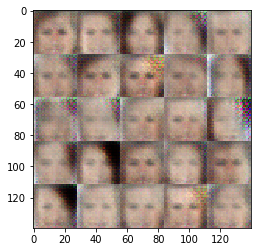

Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 6.6945
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 7.3521
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 8.5595
Epoch 1/1... Discriminator Loss: 0.0272... Generator Loss: 8.1657
Epoch 1/1... Discriminator Loss: 4.7661... Generator Loss: 0.0145
Epoch 1/1... Discriminator Loss: 0.2022... Generator Loss: 3.1341
Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 5.5755
Epoch 1/1... Discriminator Loss: 0.0268... Generator Loss: 7.4152
Epoch 1/1... Discriminator Loss: 0.0123... Generator Loss: 6.4736
Epoch 1/1... Discriminator Loss: 0.0169... Generator Loss: 7.9383


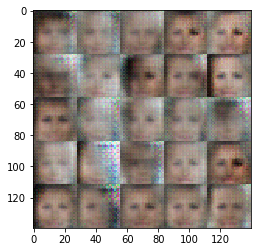

Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 7.6281
Epoch 1/1... Discriminator Loss: 0.0300... Generator Loss: 4.6181
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 7.5860
Epoch 1/1... Discriminator Loss: 0.0198... Generator Loss: 8.1788
Epoch 1/1... Discriminator Loss: 0.0091... Generator Loss: 7.5650
Epoch 1/1... Discriminator Loss: 0.0845... Generator Loss: 3.0200
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 8.7536
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 7.2232
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 10.4322
Epoch 1/1... Discriminator Loss: 0.0207... Generator Loss: 5.0046


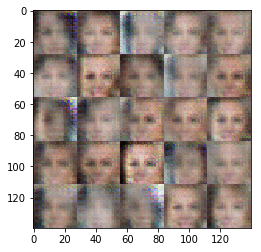

Epoch 1/1... Discriminator Loss: 0.0307... Generator Loss: 5.4737
Epoch 1/1... Discriminator Loss: 0.0145... Generator Loss: 5.4915
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 10.6563
Epoch 1/1... Discriminator Loss: 0.0367... Generator Loss: 4.1550
Epoch 1/1... Discriminator Loss: 0.0059... Generator Loss: 6.5593
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 10.3738
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 10.9465
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 6.6630
Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 9.7736
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 10.0869


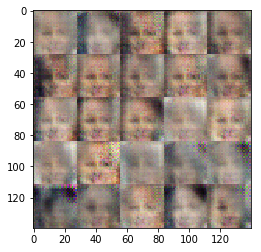

Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 9.6842
Epoch 1/1... Discriminator Loss: 0.0541... Generator Loss: 4.0935
Epoch 1/1... Discriminator Loss: 0.2534... Generator Loss: 2.7354
Epoch 1/1... Discriminator Loss: 0.0587... Generator Loss: 3.9394
Epoch 1/1... Discriminator Loss: 0.2069... Generator Loss: 2.1445
Epoch 1/1... Discriminator Loss: 3.9782... Generator Loss: 0.0263
Epoch 1/1... Discriminator Loss: 0.2905... Generator Loss: 2.8995
Epoch 1/1... Discriminator Loss: 0.2012... Generator Loss: 5.5266
Epoch 1/1... Discriminator Loss: 0.0761... Generator Loss: 5.8624
Epoch 1/1... Discriminator Loss: 0.0098... Generator Loss: 6.7714


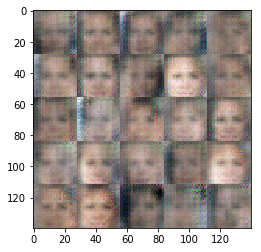

Epoch 1/1... Discriminator Loss: 0.0479... Generator Loss: 7.6399
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 8.6781
Epoch 1/1... Discriminator Loss: 0.0232... Generator Loss: 4.2892
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 8.5687
Epoch 1/1... Discriminator Loss: 0.1541... Generator Loss: 2.9062
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 7.6338
Epoch 1/1... Discriminator Loss: 0.0057... Generator Loss: 7.8201
Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 6.9320
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 5.0144
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 8.7946


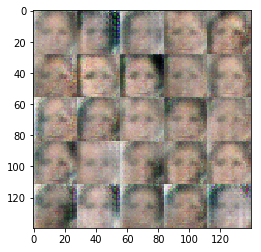

Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 8.1591
Epoch 1/1... Discriminator Loss: 0.0090... Generator Loss: 5.3855
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 8.6750
Epoch 1/1... Discriminator Loss: 0.0384... Generator Loss: 3.7377
Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 5.4864
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 7.9247
Epoch 1/1... Discriminator Loss: 0.0109... Generator Loss: 11.4756
Epoch 1/1... Discriminator Loss: 0.0106... Generator Loss: 5.2122
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 13.7585
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 9.5018


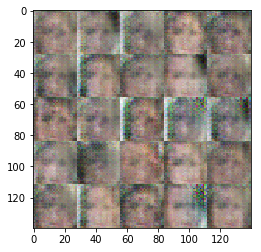

Epoch 1/1... Discriminator Loss: 0.0071... Generator Loss: 6.4307
Epoch 1/1... Discriminator Loss: 0.0049... Generator Loss: 9.5197
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 8.0930
Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 5.8224
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 10.5387
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 10.6478
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 8.8191
Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 4.8111
Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 9.0074
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 6.0691


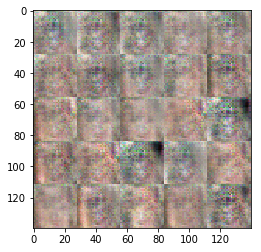

Epoch 1/1... Discriminator Loss: 0.0378... Generator Loss: 3.8299
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 5.9993
Epoch 1/1... Discriminator Loss: 0.0133... Generator Loss: 5.0779
Epoch 1/1... Discriminator Loss: 0.0835... Generator Loss: 2.8747
Epoch 1/1... Discriminator Loss: 0.0050... Generator Loss: 6.9249
Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 9.4948
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 8.4726
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 9.9550
Epoch 1/1... Discriminator Loss: 0.0298... Generator Loss: 4.1254
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 10.2984


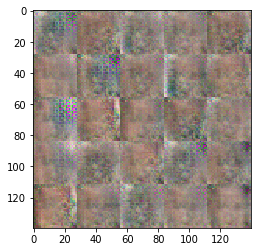

Epoch 1/1... Discriminator Loss: 0.0012... Generator Loss: 7.9607
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 8.4637
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 8.1638
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 8.6718
Epoch 1/1... Discriminator Loss: 0.0197... Generator Loss: 14.0374
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 8.5648
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 10.1861
Epoch 1/1... Discriminator Loss: 0.0001... Generator Loss: 12.3369
Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 12.0155
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 8.2555


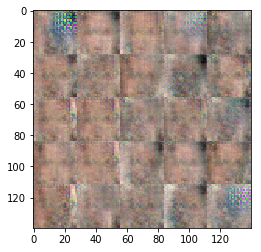

Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 9.5222
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 7.4301
Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 6.6500
Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 8.1384
Epoch 1/1... Discriminator Loss: 0.0128... Generator Loss: 5.2139
Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 6.8852
Epoch 1/1... Discriminator Loss: 2.0700... Generator Loss: 0.3891
Epoch 1/1... Discriminator Loss: 0.3366... Generator Loss: 2.2032
Epoch 1/1... Discriminator Loss: 2.0283... Generator Loss: 0.3997
Epoch 1/1... Discriminator Loss: 0.4444... Generator Loss: 2.2528


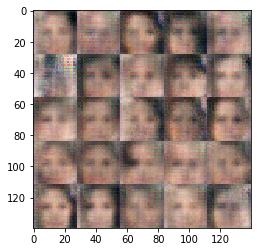

Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 0.2343... Generator Loss: 2.3077
Epoch 1/1... Discriminator Loss: 3.0414... Generator Loss: 6.5722
Epoch 1/1... Discriminator Loss: 0.0301... Generator Loss: 4.5089
Epoch 1/1... Discriminator Loss: 0.2105... Generator Loss: 3.5991
Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 1.6918
Epoch 1/1... Discriminator Loss: 0.0360... Generator Loss: 5.1713


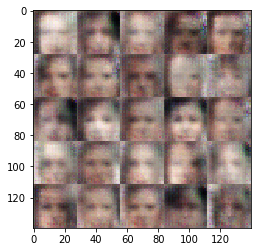

Epoch 1/1... Discriminator Loss: 0.1707... Generator Loss: 2.4971
Epoch 1/1... Discriminator Loss: 0.2074... Generator Loss: 6.7329
Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 6.7451
Epoch 1/1... Discriminator Loss: 0.0236... Generator Loss: 8.7664
Epoch 1/1... Discriminator Loss: 0.0237... Generator Loss: 6.2706
Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 9.9667
Epoch 1/1... Discriminator Loss: 0.0194... Generator Loss: 10.8838
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 7.0616
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 8.2536
Epoch 1/1... Discriminator Loss: 0.0048... Generator Loss: 9.8346


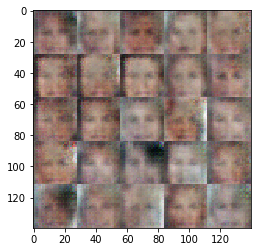

Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 9.9326
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 9.9442
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 9.3645
Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 10.6316
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 9.3680
Epoch 1/1... Discriminator Loss: 1.6017... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 0.7135... Generator Loss: 1.2301
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.7261


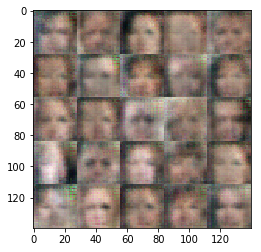

Epoch 1/1... Discriminator Loss: 2.5885... Generator Loss: 0.1487
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.6229
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 1.6507
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 0.0315... Generator Loss: 6.5897
Epoch 1/1... Discriminator Loss: 3.4902... Generator Loss: 1.9321
Epoch 1/1... Discriminator Loss: 0.3071... Generator Loss: 2.0549
Epoch 1/1... Discriminator Loss: 0.1926... Generator Loss: 4.5081
Epoch 1/1... Discriminator Loss: 0.1189... Generator Loss: 3.3034
Epoch 1/1... Discriminator Loss: 0.0342... Generator Loss: 5.2888


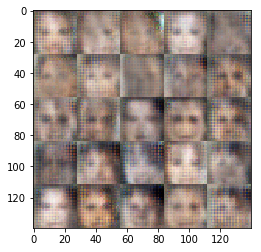

Epoch 1/1... Discriminator Loss: 0.2464... Generator Loss: 2.2786
Epoch 1/1... Discriminator Loss: 0.0607... Generator Loss: 4.1879
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.9002
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.4469
Epoch 1/1... Discriminator Loss: 0.0696... Generator Loss: 4.0197
Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 5.7415
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 0.0762... Generator Loss: 5.6688
Epoch 1/1... Discriminator Loss: 0.1193... Generator Loss: 3.8713


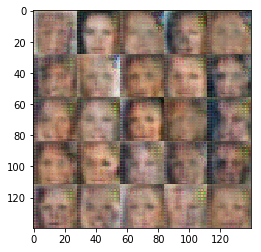

Epoch 1/1... Discriminator Loss: 0.0397... Generator Loss: 4.4167
Epoch 1/1... Discriminator Loss: 0.0101... Generator Loss: 7.4500


KeyboardInterrupt: 

In [32]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.